v1.1

The objective of this notebook is to:
- identify the best subset of features for the Random Forest Classifier

# Pre-checks

In [1]:
## Check for Google Drive Connectivity
try:
    from google.colab import drive
    drive.mount('/content/drive')
    google_env = True
except:
    print("Not a Goolge Drive Environment.")
    google_env = False

Not a Goolge Drive Environment.


In [2]:
import time
t_start = time.time()

In [3]:
# Use parameters to enable/disable the fastrun

FASTRUN = False
#FASTRUN = True

# Size of the fastrun dataframe
sample_fraction = 0.001
print("==="*40)
print("Fastrun enabled:", FASTRUN)
if FASTRUN: print("Sample size:",sample_fraction)
print("==="*40)


Fastrun enabled: False


# Setup Environment

## Install Modules

In [4]:
# Required to document module versions - required for Deepnote
#!pip install watermark

## Import Modules

In [5]:
# Base libraries
import os
from datetime import date

# Scientific libraries
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=0.8)

# Helper libraries
from watermark import watermark
from icecream import ic
import gc # garbage collection to optimize memory usage: use "gc.collect()"
import warnings
warnings.filterwarnings('ignore')

# Pandas options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Load magic commands
%load_ext watermark

## Global Parameters

In [6]:
seed = 42
cpu_count = os.cpu_count()
cpu_count = cpu_count-2  # to keep machine responsive when fitting the models
notebook_no = "04.02"

## Global Helper Functions

In [7]:
import http.client
import urllib


def send_push(message):
    """Send push notifications to pushover service."""
    try:
        conn = http.client.HTTPSConnection("api.pushover.net:443")
        conn.request("POST", "/1/messages.json",
                     urllib.parse.urlencode({
                         "token": "ahs1q4mwpnxe3645zeaqzas69whq7a",  # ML Notifications Channel
                         "user": "u5vr1qkc9ghudg2ehuug153okeiz1d",
                         "message": message,
                     }), {"Content-type": "application/x-www-form-urlencoded"})

        conn.getresponse()

    except:
        print("There was a communication issue (pushover).")


In [8]:
def fast_run_sampling(df, sample_fraction):
    print("Labels before sampling:\n", df['label'].value_counts())
    df = df.groupby('label').sample(frac=sample_fraction, random_state=seed) 
    #df = df.sample(n=sample_size, random_state=seed).reset_index(drop=True)
    print("Labels after sampling:\n", df['label'].value_counts())
    return df
    

In [9]:
def calculate_duration(t_start, t_end):
    total_runtime = t_end-t_start
    total_runtime_min = round((total_runtime/60), 2)
    print(str(total_runtime_min)+" minutes")

    return total_runtime_min


# 3.0 Load Data

In [10]:
# Load Data
if google_env:
    # Location for "shared with" people
    # create a shortcut of the shared folder in your Google Drive root folder
    ROOT_PATH = "/content/drive/MyDrive/SIADS696/Environment/"
else:
    ROOT_PATH = "../"
    print("Not a Google Drive Environment. Loading local files.")

PATH_DATA = "data/"
PATH_DATA_RAW = "data/raw/"
PATH_DATA_INT = "data/interim/"
PATH_DATA_PRO = "data/processed/"
PATH_DATA_MOD = "models/"
PATH_DATA_REP = "reports/"

# Dictionary to store file names and their corresponding dataframes
files = {
    "train_features_clean_stats.parquet.gzip": "df_wiki_train_stats",
    "test_features_clean_stats.parquet.gzip": "df_wiki_test_stats",
    "train_features_rs.parquet.gzip": "df_wiki_train_rs",
    "test_features_rs.parquet.gzip": "df_wiki_test_rs",
    "train_features_nltk.parquet.gzip": "df_wiki_train_nltk",
    "test_features_nltk.parquet.gzip": "df_wiki_test_nltk",
    "train_features_aoa.parquet.gzip": "df_wiki_train_aoa",
    "test_features_aoa.parquet.gzip": "df_wiki_test_aoa",
    "train_features_crb.parquet.gzip": "df_wiki_train_crb",
    "test_features_crb.parquet.gzip": "df_wiki_test_crb",
    "train_features_w2v.parquet.gzip": "df_wiki_train_w2v",
    "test_features_w2v.parquet.gzip": "df_wiki_test_w2v",
   # "train_mNB_predict.parquet.gzip": "df_wiki_train_MNB",  # data leakage risk
   # "test_mNB_predict.parquet.gzip": "df_wiki_test_MNB",    # data leakage risk
}

# Load data into corresponding dataframes
for file, df_name in files.items():
    if df_name not in globals():
        globals()[df_name] = pd.read_parquet(ROOT_PATH + PATH_DATA_INT + file)


Not a Google Drive Environment. Loading local files.


In [11]:
# Combine dataframes into one
df_train = pd.DataFrame()
df_train = pd.concat([df_train, df_wiki_train_stats], axis=1)
df_train = pd.concat([df_train, df_wiki_train_rs], axis=1)
df_train = pd.concat([df_train, df_wiki_train_nltk], axis=1)
df_train = pd.concat([df_train, df_wiki_train_aoa], axis=1)
df_train = pd.concat([df_train, df_wiki_train_crb], axis=1)
df_train = pd.concat([df_train, df_wiki_train_w2v], axis=1)

if FASTRUN:
    df_train = fast_run_sampling(df_train, sample_fraction)


In [12]:
df_train.shape

(416768, 155)

# RFECV for Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler

In [14]:
X_columns_train = df_train.columns.to_list()
X_columns_train = list(set(X_columns_train) -
                       {"label", "original_text", "cleaned_text", "stats_language_code"})

X = df_train[X_columns_train].copy()
y = df_train["label"]

ic(X.shape);
ic(y.shape);


ic| X.shape: (416768, 151)
ic| y.shape: (416768,)


In [15]:
k=10
skfold = StratifiedKFold(n_splits=k)
scaler = MinMaxScaler((0, 1))
rf = RandomForestClassifier(random_state=seed, n_jobs=-1)
rfecv = RFECV(estimator=rf, step=1, cv=skfold, scoring='accuracy', n_jobs=-1)


In [16]:
%%time
gc.collect()
pipeline = Pipeline([('scaler', scaler), ('rfecv', rfecv)])
pipeline.fit(X, y)


CPU times: user 1h 47min 52s, sys: 32.8 s, total: 1h 48min 25s
Wall time: 9h 7min 31s


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('rfecv',
                 RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                       estimator=RandomForestClassifier(n_jobs=-1,
                                                        random_state=42),
                       n_jobs=-1, scoring='accuracy'))])

In [17]:
if not FASTRUN: send_push(f"Optimal number of features: {rfecv.n_features_}")
ic(rfecv.n_features_);


ic| rfecv.n_features_: 125


In [18]:
best_score = max(rfecv.cv_results_['mean_test_score'])
ic(best_score);


ic| best_score: 0.7497840547061749


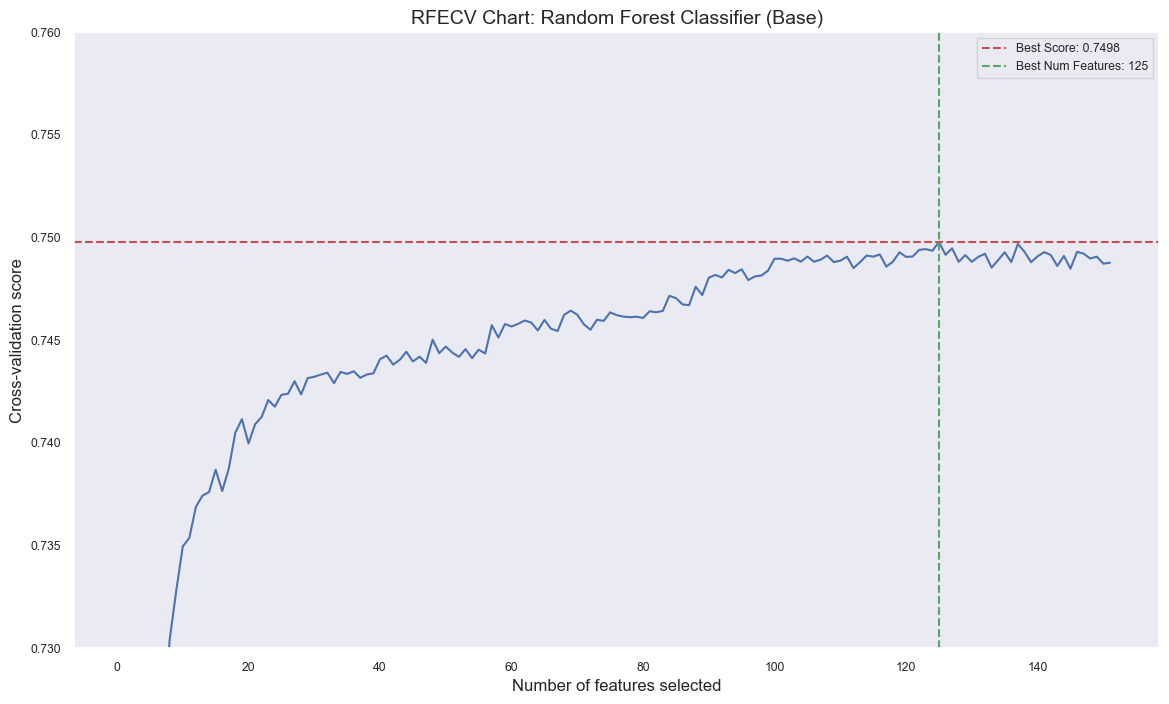

In [39]:
# Plot the number of features vs. cross-validation scores
plt.figure(figsize=(14, 8)) 
plt.title('RFECV Chart: Random Forest Classifier (Base)', fontsize=14)
plt.xlabel('Number of features selected', fontsize=12)
plt.ylabel('Cross-validation score', fontsize=12)
plt.ylim(0.73, 0.76)
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score']);
plt.grid(False)  # Remove the grid

# Add a horizontal line at the best score
best_score = max(rfecv.cv_results_['mean_test_score'])
plt.axhline(y=best_score, color='r', linestyle='--', label=f'Best Score: {best_score:.4f}')

# Add a vertical line at the number of features that achieved the best score
best_num_features = rfecv.n_features_
plt.axvline(x=best_num_features, color='g', linestyle='--', label=f'Best Num Features: {best_num_features}')

plt.legend()
plt.show();


In [40]:
today = date.today()

In [41]:
if not FASTRUN:
    plt.savefig(ROOT_PATH+PATH_DATA_REP+f'figures/{today}_RFECV{k}-RF-selected_features_chart_{notebook_no}.png');

<Figure size 1200x800 with 0 Axes>

<BarContainer object of 25 artists>

Text(0.5, 0, 'Feature Importance')

Text(0, 0.5, 'Slected Feature')

Text(0.5, 1.0, 'RFECV Random Forest Feature Importances')

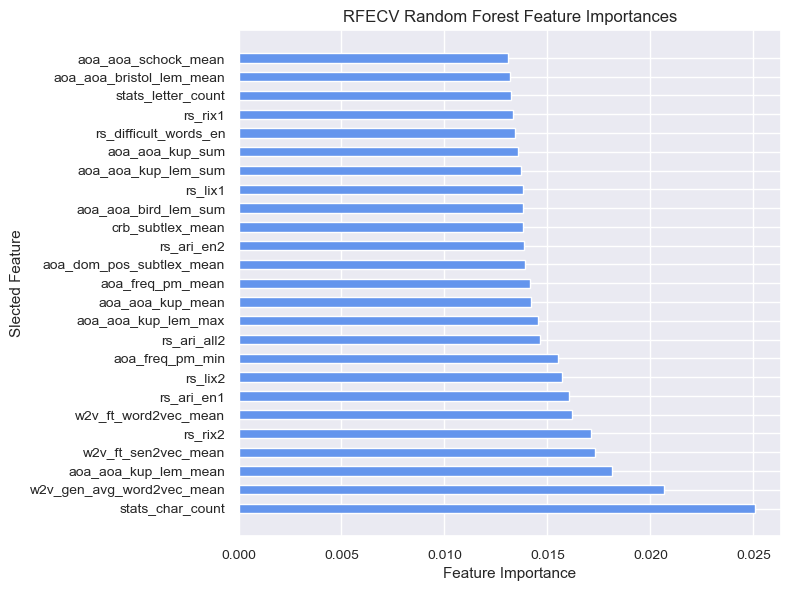

In [37]:
# Get the feature importances and names of selected features
importances = rfecv.estimator_.feature_importances_
selected_features = X.columns[rfecv.support_]

df_plot = pd.DataFrame(columns=['Selected Features', 'Importance'])
df_plot['Selected Features'] = X.columns[rfecv.support_]
df_plot['Importance'] = rfecv.estimator_.feature_importances_

df_plot = df_plot.sort_values('Importance', ascending=False)
df_plot = df_plot.head(25)

# Sort the features by importance
indices = importances.argsort()[::-1]
sorted_features = [selected_features[i] for i in indices]
sorted_importances = importances[indices]

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(5, 5))
#fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(df_plot['Selected Features'], df_plot['Importance'],
        height=0.5, color='cornflowerblue')

# Customize the chart
ax.set_xlabel('Feature Importance', fontsize=11)
ax.set_ylabel('Slected Feature', fontsize=11)
ax.set_title('RFECV Random Forest Feature Importances', fontsize=12)
ax.tick_params(axis='both', labelsize=10)
plt.tight_layout()

# Display the chart
plt.show()


In [38]:
# Save the figure
if not FASTRUN:
    plt.savefig(ROOT_PATH + PATH_DATA_REP + f'figures/{today}_RFECV{k}-RF-selected_feature_importance_chart_{notebook_no}.png');


<Figure size 1200x800 with 0 Axes>

In [28]:
t_end = time.time()
calculate_duration(t_start, t_end);


625.49 minutes


# Export

In [29]:
df_result = pd.DataFrame(columns=['Selected Features', 'Importance'])
df_result['Selected Features'] = X.columns[rfecv.support_]
df_result['Importance'] = rfecv.estimator_.feature_importances_

df_result.sort_values('Importance', ascending=False, inplace=True)

if not FASTRUN:
    df_result.to_csv(ROOT_PATH+PATH_DATA_REP+f'{today}_RFECV{k}-RF-selected_features-table_{notebook_no}.csv')
    df_result.to_csv(ROOT_PATH+PATH_DATA_INT+f'RFECV{k}-RF-selected_features-table_{notebook_no}.csv')

df_result.shape


(125, 2)

# Watermark

In [30]:
%watermark

Last updated: 2023-02-20T00:45:47.072750+01:00

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 8.9.0

Compiler    : Clang 11.0.0 
OS          : Darwin
Release     : 22.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit



In [31]:
%watermark --iversions

pandas    : 1.5.3
matplotlib: 3.6.3
numpy     : 1.23.5
seaborn   : 0.12.2



-----


In [32]:
output_file = f'{ROOT_PATH}{PATH_DATA_REP}/html/{today}_04.01_feature_selection_RFECV-RF.html'
!jupyter nbconvert --to html "04.01_feature_selection_RFECV-RF.ipynb" --output {output_file}

[NbConvertApp] Converting notebook 04.02_feature_selection_RFECV-RF_GC.ipynb to html
[NbConvertApp] Writing 820699 bytes to ../reports/html/2023-02-20_04.02_feature_selection_RFECV-RF_GC.html
